[[ 9.67457882e-01  1.77471740e-03 -3.24710171e+02]
 [-1.77471740e-03  9.67457882e-01  2.64230205e+01]]
[[ 9.67457882e-01  1.77471740e-03 -3.24710171e+02]
 [-1.77471740e-03  9.67457882e-01  2.64230205e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.28593747e+00  9.01022420e-03 -5.75076409e+02]
 [ 8.83613279e-02  1.16713178e+00 -1.04055732e+02]
 [ 1.34667823e-04  6.77610823e-06  1.00000000e+00]]
(8724, 1)
-575 -104 2048 1470


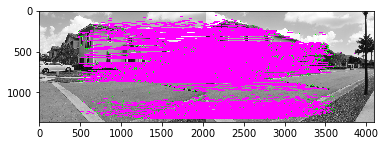

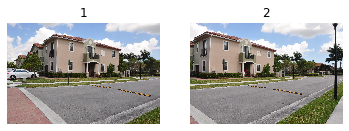

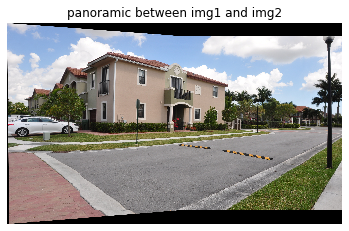

True

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  2 13:49:38 2022

@author: roux
"""


import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show, subplot, title, axis, figure


# draw matches
def draw_matches(img1, kpt1, img2, kpt2, matches):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    new_img = np.zeros((max([h1, h2]), w1 + w2, 3), dtype='uint8')
    new_img[:h1, :w1, :] = np.dstack([img1, img1, img1])
    new_img[:h2, w1:w1 + w2, :] = np.dstack([img2, img2, img2])

    # extract the match keypoints
    for m in matches:
        (x1, y1) = kpt1[m.queryIdx].pt
        (x2, y2) = kpt2[m.trainIdx].pt

        # Draw circles on the keypoints
        cv.circle(new_img, (int(x1), int(y1)), 4, (0, 255, 0), 1)
        cv.circle(new_img, (int(x2) + w1, int(y2)), 4, (0, 255, 0), 1)

        # Connect the same keypoints
        cv.line(new_img, (int(x1), int(y1)), (int(x2) + w1, int(y2)), (255, 0, 255), 1)

    return new_img


def warpImages(img1, img2, M):
    # get the corner coordinates of the "query" and "train" image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts_corners_src = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts_corners_temp = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # When we have established a homography we need to warp perspective
    # perform perspective tranform using previously calculated matrix and the corners of  
    #"query" image#
    # Change field of view
    pts_corners_dst = cv.perspectiveTransform(pts_corners_temp, M)

    ListOfPoints = np.concatenate((pts_corners_src, pts_corners_dst), axis=0)

    [x_min, y_min] = np.int32(ListOfPoints.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(ListOfPoints.max(axis=0).ravel() + 0.5)

    print(x_min,y_min,x_max,y_max)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 
1]])

    new_img = cv.warpPerspective(img2, H_translation.dot(M), (x_max - x_min, y_max - y_min))
    new_img[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = img1

    return new_img

def warpImages2(img1, img2, M):
    # get the corner coordinates of the "query" and "train" image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts_corners_src = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts_corners_temp = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # When we have established a homography we need to warp perspective
    # perform perspective tranform using previously calculated matrix and the corners of  
    #"query" image#
    # Change field of view
    pts_corners_dst = cv.perspectiveTransform(pts_corners_temp, M)

    ListOfPoints = np.concatenate((pts_corners_src, pts_corners_dst), axis=0)

    [x_min, y_min] = np.int32(ListOfPoints.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(ListOfPoints.max(axis=0).ravel() + 0.5)

    print(x_min,y_min,x_max,y_max)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 
1]])

    print(M)
    print (H_translation)

    new_img = cv.warpPerspective(img2, M-H_translation, (x_max - x_min, y_max - y_min))
    new_img[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = img1

    return new_img


def find_homography(kpt1, kpt2, matches):
    # Find an Homography matrix between two pictures
    # Transforming keypoints to list of points
    src_pts = np.float32([kpt1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kpt2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute a rigid transformation (without depth, only scale + rotation + translation) /affine transformation
    transformation_rigid_matrix, mask = cv.estimateAffine2D(src_pts, dst_pts)
    transformation_rigid_matrix, mask = cv.estimateAffinePartial2D(src_pts, dst_pts)

    print(transformation_rigid_matrix)
    
    affine_row = [0, 0, 1]
    transformation_rigid_matrix = np.vstack((transformation_rigid_matrix, affine_row))
    
    print(transformation_rigid_matrix)

    M, mask = cv.findHomography(src_pts, dst_pts,cv.RANSAC,0.5)
    matchesMask = mask.ravel().tolist()

    print(M)
    print(mask.shape)
    
    #return transformation_rigid_matrix,matchesMask

    return M,matchesMask


img1c = cv.imread('004.jpg', 1)
img2c = cv.imread('005.jpg', 1)

img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2c, cv.COLOR_BGR2GRAY)

img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)
img2c = cv.cvtColor(img2c, cv.COLOR_BGR2RGB)




# Initiate ORB detector, that it will be our detector object.
orb = cv.ORB_create(100000)



# find the keypoints and compute the descriptors with ORB for images
kpts1, des1 = orb.detectAndCompute(img1, None)
kpts2, des2 = orb.detectAndCompute(img2, None)


# Create a BFMatcher object.
bf = cv.BFMatcher_create(cv.NORM_HAMMING)

# match descriptor
matches1to2 = bf.knnMatch(des1, des2, k=2)


# draw matches
good1to2 = []
for m, n in matches1to2:
    if m.distance < 0.6 * n.distance:
        good1to2.append(m)

drawimg=draw_matches(img1, kpts1, img2, kpts2, good1to2)


# find  affine transformation and panoramic view between 1 to 2
matrix1to2,M12 = find_homography(kpts1, kpts2, good1to2)
img1to2 = warpImages(img2c, img1c, matrix1to2)

figure()

imshow(drawimg)
show()


figure()

subplot(1, 2, 1)
imshow(img1c)
axis('off')
title('1')

subplot(1, 2, 2)
imshow(img2c)
axis('off')
title('2')

show()

figure()

title1 = "panoramic between img1 and img2"

subplot(1, 1, 1)
imshow(img1to2)
axis('off')
title(title1)

show()

img1to2 = cv.cvtColor(img1to2, cv.COLOR_BGR2RGB)
cv.imwrite('panorama13.jpg',img1to2)



